# MNIST classifier in IBM FL

## Outline:
- [Add conda environment to Jupyter Notebook](#setup)
- [Federated Learning(FL)](#intro)
- [Digit Recognition](#mnist)
- [Parties](#Parties)
    - [Party Configuration](#Party-Configuration)
    - [Party Setup](#Party-Setup)
- [Register All Parties Before Starting Training](#Register-All-Parties-Before-Starting-Training)
- [Visualize Results](#Visualize-Results)
- [Shut Down](#Shut-Down)

## Add conda environment to Jupyter Notebook <a name="setup"></a>

Please ensure that you have activated the `conda` environment following the instructions in the project README.

Once done, run the following commands in your terminal to install your conda environment into the Jupyter Notebook:

1. Once you have activated the conda environment, install the `ipykernel` package: `conda install -c anaconda ipykernel`

2. Next, install the `ipykernel` module within Jupyter Notebook: `python -m ipykernel install --user --name=<conda_env>`

3. Please install the `matplotlib` package for your conda environment. 

4. Finally, restart the jupyter notebook once done. Ensure that you are running this Notebook from `<project_path>/Notebooks`, where project_path is the directory where the IBMFL repository was cloned.

When the Notebook is up and running it may prompt you to choose the kernel. Use the drop down to choose the kernel name same as that chosen when running `conda activate <conda_env>`. If no prompt shows up, you can change the kernel by clicking _Kernel_ > _Change kernel_ > _`<conda_env>`_.

## Federated Learning (FL) <a name="intro"></a>

**Federated Learning (FL)** is a distributed machine learning process in which each participant node (or party) retains their data locally and interacts with  other participants via a learning protocol. 
One main driver behind FL is the need to not share data with others  due to privacy and confidentially concerns.
Another driver is to improve the speed of training a machine learning model by leveraging other participants' training processes.

Setting up such a federated learning system requires setting up a communication infrastructure, converting machine learning algorithms to federated settings and in some cases knowing about the intricacies of security and privacy enabling techniques such as differential privacy and multi-party computation. 

In this Notebook we use [IBM FL](https://github.com/IBM/federated-learning-lib) to have multiple parties train a classifier to recognise handwritten digits in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). 

For a more technical dive into IBM FL, refer the whitepaper [here](https://arxiv.org/pdf/2007.10987.pdf).

In the following cells, we set up each of the components of a Federated Learning network (See Figure below) wherein all involved parties aid in training their respective local cartpoles to arrive at the upright pendulum state. In this notebook we default to 2 parties, but depending on your resources you may use more parties.

<img src="../images/FL_Network.png" width="720"/>
<figcaption><center>Modified from Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>

## Digit Recognition <a name="mnist"></a>



<img src="../images/MnistExamples.png" width="512"/>
<figcaption><center>Image Source: Josef Steppan / CC BY-SA <a href="https://creativecommons.org/licenses/by-sa/4.0">Wikimedia Commons</a></center></figcaption>

The problem at hand is to recognize digits from these tens of thousands of handwritten images. 

### Getting things ready
We begin by setting the number of parties that will participate in the federated learning run and splitting up the data among them.

In [1]:
import sys
party_id = 0

sys.path.append('../..')
import os
os.chdir("../..")

num_parties = 2  ## number of participating parties
dataset = 'mnist'

## Parties

Each party holds its own dataset that is kept to itself and used to answer queries received from the aggregator. Because each party may have stored data in different formats, FL offers an abstraction called Data Handler. This module allows for custom implementations to retrieve the data from each of the participating parties. A local training handler sits at each party to control the local training happening at the party side. 

### Party Configuration

**Note**: in a typical FL setting, the parties may have very different configurations from each other. However, in this simplified example, the config does not differ much across parties. So, we first setup the configuration common to both parties, in the next cell. We discuss the parameters that are specific to each, in subsequent cells.

<img src="../images/arch_party.png" width="680"/>
<figcaption><center>Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>

### Party Setup
In the following cell, we setup configurations for parties, including network-level details, hyperparameters as well as the model specifications. Please note that if you are running this notebook in distributed environment on separate nodes then you need to split the data locally and obtain the model h5 generated by the Aggregator.

#### Building Blocks in Party Configuration:

Now we configure party specific configurations in the `get_party_config` method, which specifies model related configurations as well as other parameters necessary for the federated learning setup. The model related configurations are identical to those generated (yaml files) during the terminal run.

Once these are done, we invoke them for each party, in the subsequent cell.

- `local_training_handler`: handles the train and eval commands, also initializes data, environment and models

- `protocol_handler`: party protocol handler communicates with the Aggregator bridging between Aggregator and local training handler

- `aggregator`: IP and port at which the Aggregator is running, so the party may connect to it

- `data`: information needed to initiate a data handler class; includes a given data path, a data handler class name, and a data handler file location

- `model`: details about the model, including name, the model class file location, i.e., path, and the given model specification path, i.e., spec. In this example, we use the Keras FL Model class, as indicated under the spec

**Note**: in a typical FL setting, the parties may have very different configurations from each other. However, in this simplified example, the config does not differ much across parties. Also, as of this release all parties registered with the aggregator participate in the training. Dynamically letting registered parties to skip training in certain rounds will be supported in subsequent versions.

In [2]:
def get_party_config(party_id):
    party_config = {
        'aggregator':
            {
                'ip': '127.0.0.1',
                'port': 5000
            },
        'connection': {
            'info': {
                'ip': '127.0.0.1',
                'port': 8085 + party_id,
                'id': 'party' + str(party_id),
                'tls_config': {
                    'enable': False
                }
            },
            'name': 'FlaskConnection',
            'path': 'ibmfl.connection.flask_connection',
            'sync': False
        },
        'data': {
            'info': {
                'npz_file': 'examples/data/mnist/random/data_party'+ str(party_id) +'.npz'
            },
            'name': 'MnistKerasDataHandler',
            'path': 'ibmfl.util.data_handlers.mnist_keras_data_handler'
        },
        'local_training': {
            'name': 'LocalTrainingHandler',
            'path': 'ibmfl.party.training.local_training_handler'
        },
        'model': {
            'name': 'KerasFLModel',
            'path': 'ibmfl.model.keras_fl_model',
            'spec': {
                'model_definition': 'examples/configs/keras_classifier/compiled_keras.h5',
                'model_name': 'keras-cnn'
            }
        },
        'protocol_handler': {
            'name': 'PartyProtocolHandler',
            'path': 'ibmfl.party.party_protocol_handler'
        }
    }
    return party_config


### Running the Party

Now, we invoke the `get_party_config` function to setup party and `start()` it.

Finally, we register the party with the Aggregator.

In [3]:
from ibmfl.party.party import Party
import tensorflow as tf

party_config = get_party_config(party_id)
party = Party(config_dict=party_config)
party.start()
party.register_party()
party.proto_handler.is_private = False  ## allows sharing of metrics with aggregator

//anaconda2/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda2/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda2/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda2/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dty

2020-10-05 15:17:37,278 -STD ibmfl.util.config - INFO - Getting Aggregator details from arguments.


Using TensorFlow backend.


2020-10-05 15:17:39,658 -STD ibmfl.util.config - INFO - No fusion config provided for this setup.
Instructions for updating:
Colocations handled automatically by placer.
2020-10-05 15:17:40,421 -STD tensorflow - WARNING - From //anaconda2/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2020-10-05 15:17:40,639 -STD tensorflow - WARNING - From //anaconda2/envs/myenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - k

2020-10-05 15:18:36,113 -STD werkzeug - INFO - 127.0.0.1 - - [05/Oct/2020 15:18:36] "POST /7 HTTP/1.1" 200 -
2020-10-05 15:18:36,117 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  7
2020-10-05 15:18:36,121 -STD ibmfl.party.party_protocol_handler - INFO - Received request in PH 7
2020-10-05 15:18:36,123 -STD ibmfl.util.data_handlers.mnist_keras_data_handler - INFO - Loaded training data from examples/data/mnist/random/data_party0.npz
x_train shape: (200, 28, 28, 1)
200 train samples
5000 test samples
2020-10-05 15:18:36,178 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-05 15:18:36,179 -STD ibmfl.party.training.local_training_handler - INFO - Local training started...
2020-10-05 15:18:36,180 -STD ibmfl.model.keras_fl_model - INFO - Using default hyperparameters:  batch_size:128
Epoch 1/3
200/200 [==============================] - 1s 3ms/step - loss: 1.0383 - acc: 0.7200
Epoch 2/3
200/200 [=================

2020-10-05 15:19:16,571 -STD ibmfl.util.data_handlers.mnist_keras_data_handler - INFO - Loaded training data from examples/data/mnist/random/data_party0.npz
x_train shape: (200, 28, 28, 1)
200 train samples
5000 test samples
5000/5000 [==============================] - 6s 1ms/step
2020-10-05 15:19:22,421 -STD ibmfl.party.training.local_training_handler - INFO - {'loss': 0.4681588929176331, 'acc': 0.848}
2020-10-05 15:19:22,433 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async request
2020-10-05 15:19:27,627 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-05 15:19:27,702 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2020-10-05 15:19:27,703 -STD ibmfl.party.party_protocol_handler - INFO - finished async request
2020-10-05 15:19:27,705 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-05 15:19:27,712 -STD ibmfl.party.party_protocol_handler - INFO -

2020-10-05 15:19:59,072 -STD ibmfl.party.party_protocol_handler - INFO - Received request in PH 7
2020-10-05 15:19:59,074 -STD ibmfl.util.data_handlers.mnist_keras_data_handler - INFO - Loaded training data from examples/data/mnist/random/data_party0.npz
x_train shape: (200, 28, 28, 1)
200 train samples
5000 test samples
2020-10-05 15:19:59,172 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-05 15:19:59,175 -STD ibmfl.party.training.local_training_handler - INFO - Local training started...
2020-10-05 15:19:59,178 -STD ibmfl.model.keras_fl_model - INFO - Using default hyperparameters:  batch_size:128
Epoch 1/3
200/200 [==============================] - 1s 7ms/step - loss: 0.1575 - acc: 0.9550
Epoch 2/3
200/200 [==============================] - 1s 7ms/step - loss: 0.2203 - acc: 0.9300
Epoch 3/3
200/200 [==============================] - 1s 6ms/step - loss: 0.1084 - acc: 0.9700
2020-10-05 15:20:03,063 -STD ibmfl.party.training.local_training_handler

x_train shape: (200, 28, 28, 1)
200 train samples
5000 test samples
5000/5000 [==============================] - 5s 1ms/step
2020-10-05 15:20:59,902 -STD ibmfl.party.training.local_training_handler - INFO - {'loss': 0.37322228217124936, 'acc': 0.8964}
2020-10-05 15:20:59,911 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async request
2020-10-05 15:21:01,824 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-05 15:21:01,894 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2020-10-05 15:21:01,896 -STD ibmfl.party.party_protocol_handler - INFO - finished async request
2020-10-05 15:21:01,896 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-05 15:21:01,900 -STD werkzeug - INFO - 127.0.0.1 - - [05/Oct/2020 15:21:01] "POST /7 HTTP/1.1" 200 -
2020-10-05 15:21:01,900 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-05 1

2020-10-05 15:21:27,748 -STD ibmfl.util.data_handlers.mnist_keras_data_handler - INFO - Loaded training data from examples/data/mnist/random/data_party0.npz
x_train shape: (200, 28, 28, 1)
200 train samples
5000 test samples
2020-10-05 15:21:27,797 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-05 15:21:27,799 -STD ibmfl.party.training.local_training_handler - INFO - Local training started...
2020-10-05 15:21:27,801 -STD ibmfl.model.keras_fl_model - INFO - Using default hyperparameters:  batch_size:128
Epoch 1/3
200/200 [==============================] - 1s 3ms/step - loss: 0.0377 - acc: 0.9900
Epoch 2/3
200/200 [==============================] - 1s 3ms/step - loss: 0.0381 - acc: 1.0000
Epoch 3/3
200/200 [==============================] - 1s 3ms/step - loss: 0.0443 - acc: 0.9850
2020-10-05 15:21:29,587 -STD ibmfl.party.training.local_training_handler - INFO - Local training done, generating model update...
2020-10-05 15:21:29,592 -STD ibmfl.util.

x_train shape: (200, 28, 28, 1)
200 train samples
5000 test samples
2020-10-05 15:22:24,732 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-05 15:22:24,734 -STD ibmfl.party.training.local_training_handler - INFO - Local training started...
2020-10-05 15:22:24,736 -STD ibmfl.model.keras_fl_model - INFO - Using default hyperparameters:  batch_size:128
Epoch 1/3
200/200 [==============================] - 1s 3ms/step - loss: 0.0267 - acc: 0.9900
Epoch 2/3
200/200 [==============================] - 1s 3ms/step - loss: 0.0109 - acc: 1.0000
Epoch 3/3
200/200 [==============================] - 1s 3ms/step - loss: 0.0200 - acc: 1.0000
2020-10-05 15:22:26,723 -STD ibmfl.party.training.local_training_handler - INFO - Local training done, generating model update...
2020-10-05 15:22:26,731 -STD ibmfl.util.data_handlers.mnist_keras_data_handler - INFO - Loaded training data from examples/data/mnist/random/data_party0.npz
x_train shape: (200, 28, 28, 1)
200 trai

2020-10-05 15:22:57,333 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async request
2020-10-05 15:23:00,665 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-05 15:23:00,785 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2020-10-05 15:23:00,786 -STD ibmfl.party.party_protocol_handler - INFO - finished async request
2020-10-05 15:23:00,787 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-05 15:23:00,790 -STD werkzeug - INFO - 127.0.0.1 - - [05/Oct/2020 15:23:00] "POST /7 HTTP/1.1" 200 -
2020-10-05 15:23:00,792 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-05 15:23:00,795 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  7
2020-10-05 15:23:00,796 -STD ibmfl.party.party_protocol_handler - INFO - Received request in PH 7
2020-10-05 15:23:00,797 -STD ibmfl.util.data_handle

## Register All Parties Before Starting Training

Now we have started and registered this Party. Next, we will start and register rest of the parties. Once all the Parties have registered we will go back to the Aggregator's notebook to start training.

## Visualize Results

Here we plot the summary graphs from each party's training.

In [4]:
import keras
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
_, (X_test, Y_test) = mnist.load_data()

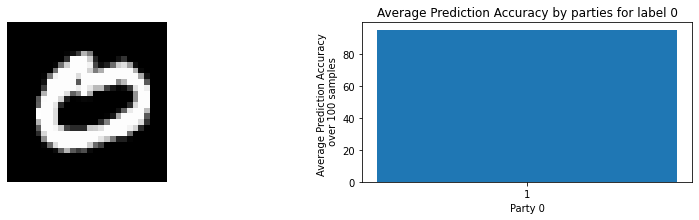

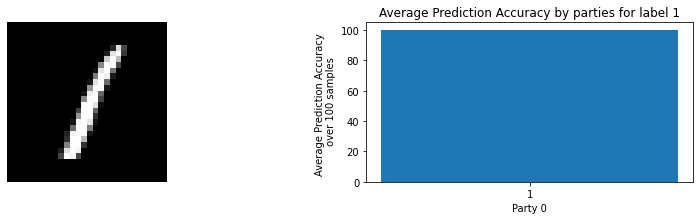

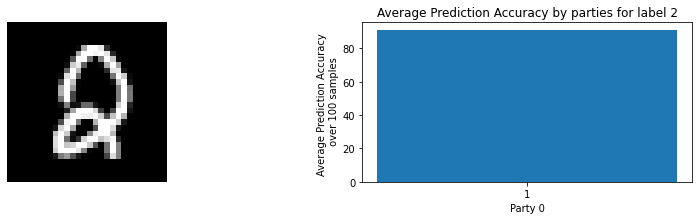

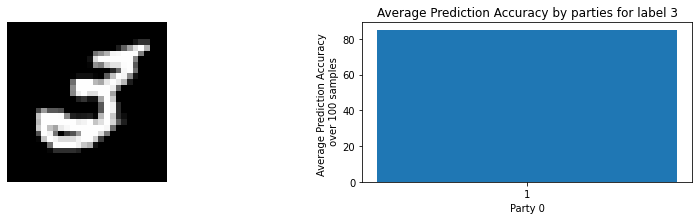

2020-10-05 15:23:59,115 -STD ibmfl.connection.flask_connection - INFO - Request received for path :14
2020-10-05 15:23:59,120 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-05 15:23:59,122 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  14
2020-10-05 15:23:59,124 -STD ibmfl.party.party_protocol_handler - INFO - Received request in PH 14
2020-10-05 15:23:59,125 -STD ibmfl.party.party_protocol_handler - INFO - received a STOP request
2020-10-05 15:23:59,129 -STD werkzeug - INFO - 127.0.0.1 - - [05/Oct/2020 15:23:59] "POST /14 HTTP/1.1" 200 -


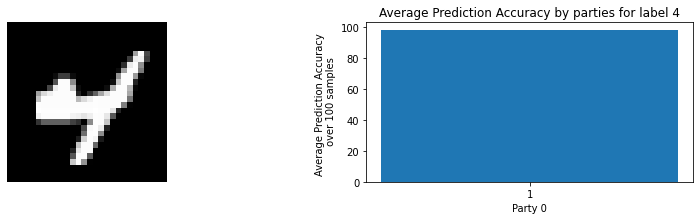

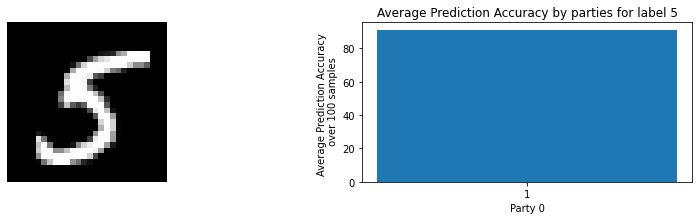

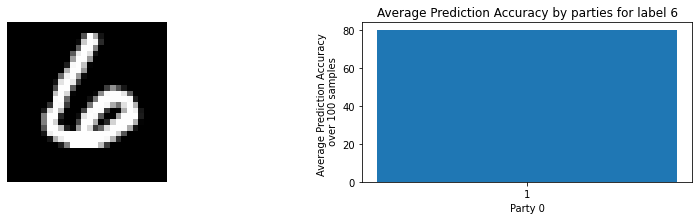

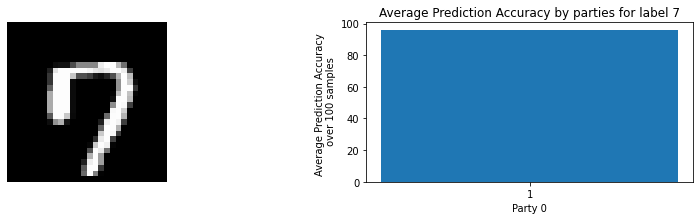

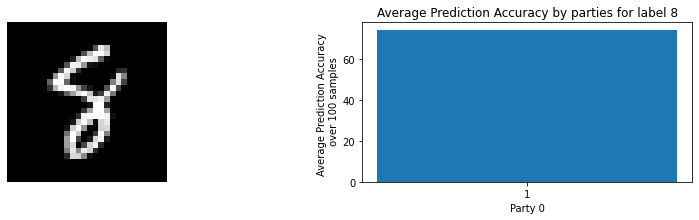

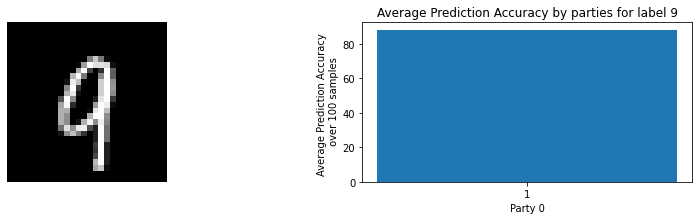

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import keras
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
sample_count = 100
num_parties = 1
for i in range(10):
   test_filter = np.where(Y_test == i)
   X_test1, Y_test1 = X_test[test_filter], Y_test[test_filter]
   #labels, counts = np.unique(Y_test1, return_counts=True)
   np.random.seed(123)
   rand_v = np.random.randint(0, X_test1.shape[0],sample_count)
   test_digits = X_test1[rand_v]
   test_labels = Y_test1[rand_v]
   labels, counts = np.unique(test_labels, return_counts=True)
   #print('Original lable', labels)
   acc_list = np.array([])
   y_true = np.full(sample_count, i)

       
   y_pred = np.array([])
   for i_samples in range(sample_count):
      pred = party.fl_model.predict(test_digits[i_samples].reshape(1, 28, 28, 1))
      y_pred = np.append(y_pred, pred.argmax())
   acc = accuracy_score(y_true, y_pred) * 100
   #print('y prediction',y_pred)
   #print('y true',y_true)
   #print('accuracy',acc)
   acc_list = np.append(acc_list,acc)

   ind = np.arange(num_parties) 
   fig2 = plt.figure(constrained_layout=True,figsize=(10,10))
   fig2.tight_layout()
   spec2 = gridspec.GridSpec(ncols=6, nrows=4, figure=fig2) 
   f2_ax1 = fig2.add_subplot(spec2[0:1, 0:2])
   f2_ax1.imshow(test_digits[0], cmap='gray')
   plt.axis('off')
   f2_ax2 = fig2.add_subplot(spec2[0:1, 3:])
   labels = [(i+1) for i in range(num_parties)] 
   
   x = np.arange(num_parties)
  

   rects1 = f2_ax2.bar(x, acc_list, width=0.3)
   # Add some text for labels, title and custom x-axis tick labels, etc.
   f2_ax2.set_xlabel('Party ' + str(party_id))
   f2_ax2.set_ylabel('Average Prediction Accuracy \n over '+str(sample_count)+' samples')
   f2_ax2.set_title('Average Prediction Accuracy by parties for label '+str(i))
   f2_ax2.set_xticks(x)
   f2_ax2.set_xticklabels(labels)

## Shut Down

Invoke the `stop()` method on each of the network participants to terminate the service.

In [9]:
party.stop()

2020-10-03 23:07:38,861 -STD ibmfl.connection.flask_connection - INFO - Stopping Receiver and Sender
2020-10-03 23:07:38,867 -STD werkzeug - INFO - 127.0.0.1 - - [03/Oct/2020 23:07:38] "POST /shutdown HTTP/1.1" 200 -
2020-10-03 23:07:38,869 -STD ibmfl.party.party - INFO - Party stop successful
